# Train fourier features network

_Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains_

References [1](https://github.com/tancik/fourier-feature-networks), [2](https://bmild.github.io/fourfeat/), [3](https://arxiv.org/abs/2006.10739)

In [ ]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet
!pip install imageio --quiet
!pip install matplotlib --quiet

#### Imports

In [1]:
from __future__ import annotations
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt  # visualization
import imageio
from typing_extensions import Annotated
import numpy as np
import serket as sk
import optax
import functools as ft

#### Data preparation

image.shape=(512, 512, 3)


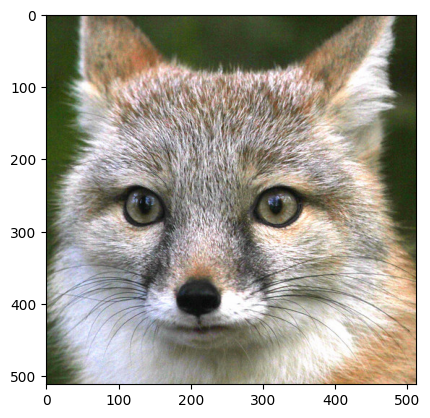

In [2]:
# load and preprocess image

url = "https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg"
image = imageio.v2.imread(url)
image = sk.nn.CenterCrop2D(512)(image.transpose(2, 0, 1)).transpose(1, 2, 0)
print(f"{image.shape=}")
plt.imshow(image)

In [3]:
# create a 2D grid of coordinates
# in essence we need to create a mapping from the 2D grid to an RGB grid

# first we normalize the coordinates and the image
image = image / 255.0
line = jnp.linspace(0, 1, image.shape[0], endpoint=False)

# x,y coordinates stacked in the last axis
coord: Annotated[jax.Array, "HW2"] = jnp.stack(jnp.meshgrid(line, line), axis=-1)
train_data = [coord[::2, ::2], image[::2, ::2]]  # downsampled data by 2
test_data = [coord, image]

print("Train data:\t", jax.tree_map(lambda x: x.shape, train_data))
print("Test data:\t", jax.tree_map(lambda x: x.shape, test_data))

Train data:	 [(256, 256, 2), (256, 256, 3)]
Test data:	 [(512, 512, 2), (512, 512, 3)]


#### Neural network

The model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

The following mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

<!-- - Positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(2 \pi \sigma^{j/m} \mathbf{v}),\sin(2 \pi \sigma^{j/m} \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, m-1$.  -->

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$

References [1](https://github.com/tancik/fourier-feature-networks), [2](https://bmild.github.io/fourfeat/), [3](https://arxiv.org/abs/2006.10739)

In [4]:
M = 256  # number of intermediate features
D = 2  # dimension of the input


def mse(x: jax.Array, y: jax.Array) -> jax.Array:
    assert x.shape == y.shape, f"{x.shape=} != {y.shape=}"
    return jnp.mean((x - y) ** 2)


@ft.partial(jax.grad, has_aux=True)
def loss_func(net: sk.nn.FNN, x: jax.Array, y: jax.Array) -> jax.Array:
    # unmask the net after crossing jax transformation boundaries
    # before calling the network on the input
    ypred = sk.tree_unmask(net)(x)
    mse_loss = mse(ypred, y)
    # the aux is returned as the second element of the tuple
    return mse_loss, mse_loss


@jax.jit
def train_step(
    net: sk.nn.FNN,
    optim_state: optax.OptState,
    train_data: tuple[jax.Array, jax.Array],
):
    grad, mse_loss = loss_func(net, *train_data)
    updates, optim_state = optim.update(grad, optim_state)
    net = optax.apply_updates(net, updates)
    return net, optim_state, mse_loss


def project(
    x: Annotated[jax.Array, "HWD"], b: Annotated[jax.Array, "MD"]
) -> Annotated[jax.Array, "HW(2M)"]:
    projection = (2 * jnp.pi * x) @ b.T
    return jnp.concatenate([jnp.sin(projection), jnp.cos(projection)], axis=-1)

##### No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

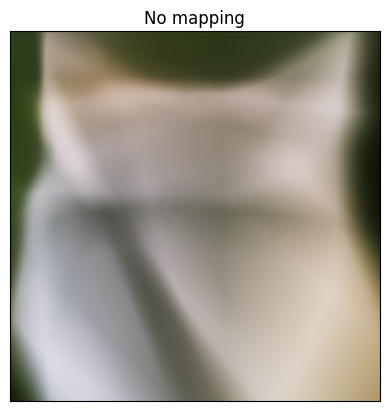

In [5]:
# define net
net = sk.Sequential(
    sk.nn.FNN([2] + [M] * 4 + [3], act="relu", key=jax.random.PRNGKey(0)),
    jax.nn.sigmoid,
)
# pass non-jaxtype through jax transformation boundaries
net = sk.tree_mask(net)
# define optimizer
optim = optax.adam(1e-4)
# initialize the optimizer state
optim_state = optim.init(net)

for i in range(1000):
    net, optim_state, mse_loss = train_step(net, optim_state, train_data)

net = sk.tree_unmask(net)
plt.imshow(net(test_data[0]))
plt.xticks([])
plt.yticks([])
plt.title(f"No mapping")
plt.show()

##### Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

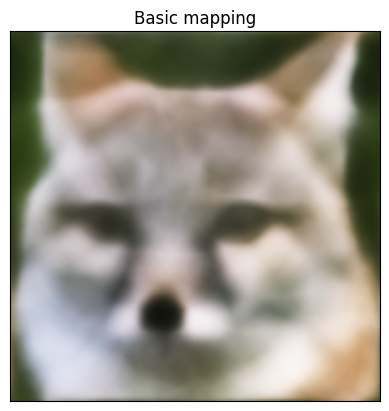

In [6]:
# define net
net = sk.Sequential(
    sk.nn.FNN([2 * 2] + [M] * 4 + [3], act="relu", key=jax.random.PRNGKey(0)),
    jax.nn.sigmoid,
)
# pass non-jaxtype through jax transformation boundaries
net = sk.tree_mask(net)
# define optimizer
optim = optax.adam(1e-4)
# initialize the optimizer state
optim_state = optim.init(net)
projected_data = (project(train_data[0], jnp.eye(2)), train_data[1])

for i in range(1000):
    net, optim_state, mse_loss = train_step(net, optim_state, projected_data)

net = sk.tree_unmask(net)
plt.imshow(net(project(test_data[0], jnp.eye(2))))
plt.xticks([])
plt.yticks([])
plt.title(f"Basic mapping")
plt.show()

##### Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$

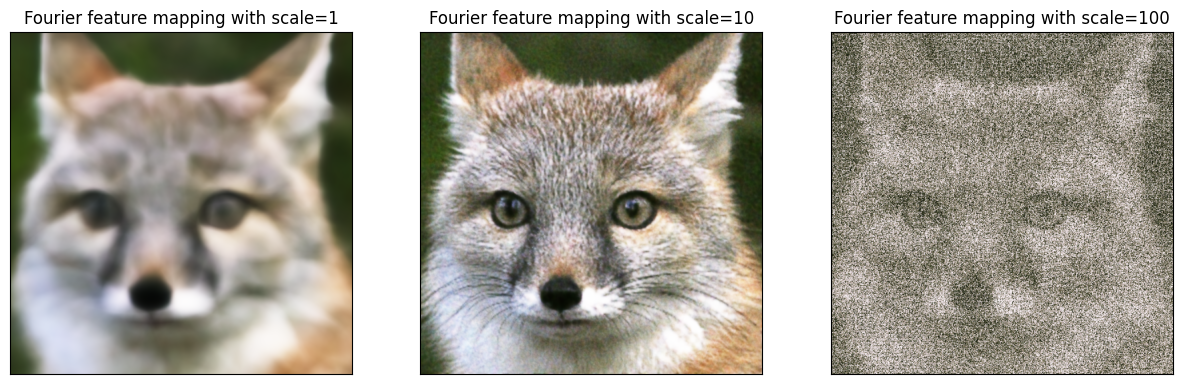

In [7]:
b1, b2, b3 = jax.vmap(jr.normal, in_axes=(0, None))(jr.split(jr.PRNGKey(0), 3), [M, D])
b1 = b1 * 1
b2 = b2 * 10
b3 = b3 * 100

fig, axes = plt.subplots(1, 3, figsize=(15, 7))


for index, bi in enumerate([b1, b2, b3]):
    # define net
    net = sk.Sequential(
        sk.nn.FNN([2 * M] + [M] * 4 + [3], act="relu", key=jax.random.PRNGKey(0)),
        jax.nn.sigmoid,
    )
    # get only parameters
    net = sk.tree_mask(net)
    # define optimizer
    optim = optax.adam(1e-4)
    # initialize the optimizer state
    optim_state = optim.init(net)
    # project input data
    projected_data = (project(train_data[0], bi), train_data[1])

    for i in range(1000):
        net, optim_state, mse_loss = train_step(net, optim_state, projected_data)

    net = sk.tree_unmask(net)
    axes[index].imshow(net(project(test_data[0], bi)))
    axes[index].set_xticks([])
    axes[index].set_yticks([])
    axes[index].set_title(f"Fourier feature mapping with scale={[1,10,100][index]}")
plt.show()